# Project Description 

This project aims to create a pipeline for image processing to detect lane lines based on camera images. The code below has been broken into different subsections, with each representing a function for the lane-finding algorithm. The pipeline can be broken down into the following sequence: 
1. Camera calibration: Calibrating the camera for distortion correction 
2. Perspective transform: Unwarping the image to transform the camera perspective into a bird's eye view of the lane lines for lane detection 
3. Lane finding: Passing the image through selected colorspaces to identify the color thresholds of pixels for lane detection. This step will output a black and white image for the next step
4. Sliding window search: Taking in a black and white image from the previous step to perform a sliding window convolution to search for the lane lines
5. Polynomial fitting: Perform polynomial fitting to calculate the curvature of lane lines and extrapolate

In [8]:
%matplotlib inline
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import matplotlib.image as mpimg
import cv2
import pickle
import glob

plt.rcParams["figure.figsize"] = [15,9]


## 1. Camera Calibration 
This part of the code serves as the pipeline for the camera calibration to correct distortion 

In [2]:
# prepare object and image points for undistortion 
nx = 9#TODO: enter the number of inside corners in x
ny = 6#TODO: enter the number of inside corners in y

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

#        # Draw and display the corners
#        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
#        cv2.imshow('img',img)
#        cv2.waitKey(500)
#cv2.destroyAllWindows()





In [4]:
#Function definition for undistortion 
def cal_undistort(img, objpoints, imgpoints):
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, 
    imgpoints, gray.shape[::-1], None, None)
    undist = cv2.undistort(img, mtx, dist, None, mtx)

    return undist

In [5]:
#apply undistort on one of the images
img = cv2.imread('camera_cal/calibration1.jpg')
undistorted = cal_undistort(img, objpoints, imgpoints)
cv2.imwrite('camera_cal/calibration1_undistorted.jpg', undistorted)


True

## 2. Perspective Transform

This section of code adds the perspective transform to unwarp the lane line images. The main function of code performing the unwarp is in the unwarp function definition, while the parameters are fine-tuned in src and dst lists 2 kernels below. There is also a rewarp function to rewarp the frames from the camera images later. 

In [81]:
def unwarp(img, src, dst):
    M = cv2.getPerspectiveTransform(src, dst)
    img_size = (img.shape[1], img.shape[0])
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    
    return warped

In [82]:
def rewarp(img, src, dst):
    M_inv = cv2.getPerspectiveTransform(dst, src)
    img_size = (image.shape[1], image.shape[0])
    rewarped = cv2.warpPerspective(img, M_inv, img_size, flags = cv2.INTER_LINEAR)

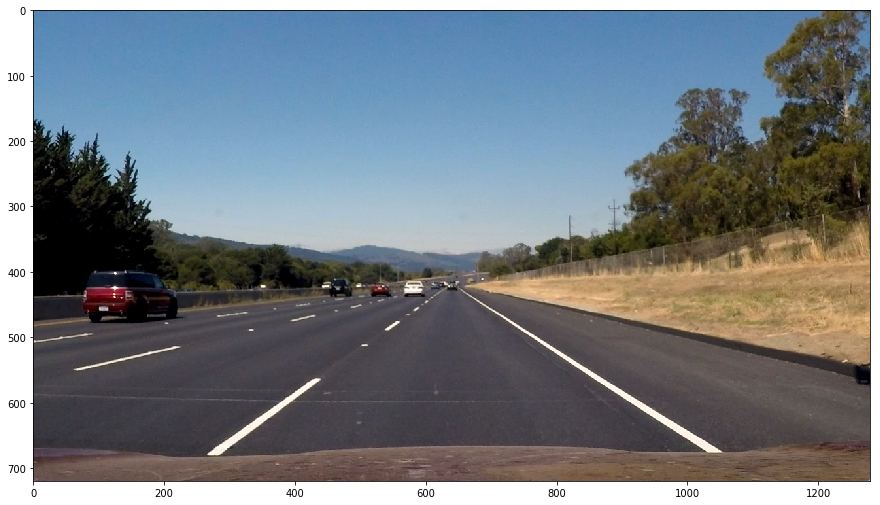

In [183]:
image = cv2.imread('test_images/straight_lines2.jpg')
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

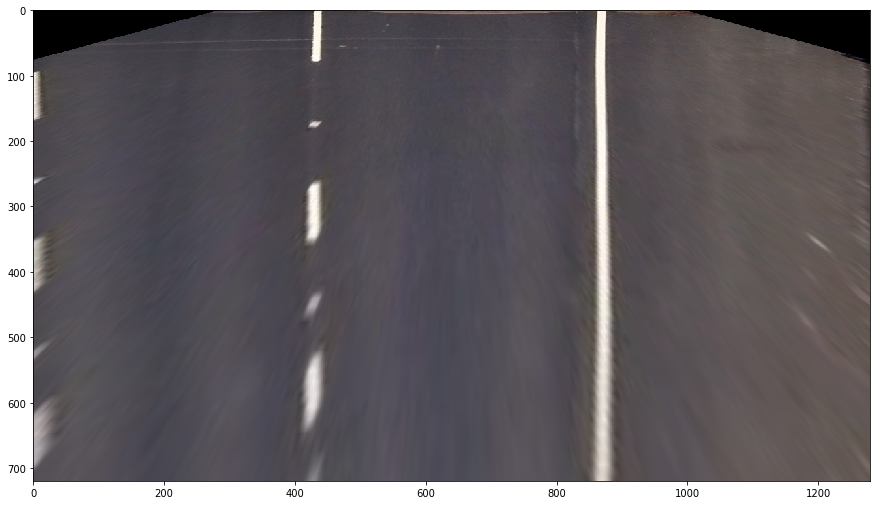

In [10]:
h = image.shape[0]
w = image.shape[1]
y = 450
src = np.float32([(300, 680), (600, 450), (980, 680), (680, 450)])
dst = np.float32([(y, 0), (y, h), (w-y, 0), (w-y, h)])

image_unwarp = unwarp(image, src, dst)
plt.imshow(image_unwarp, cmap='RdBu')


# 3. Lane Lines Identification (Part 1)
This section of code explores different types of color channels which would produce the most distinct results for identifying a lane. Several color spaces and methods were explored, namely: 
1. Lane detecton using the Sobel Operator 
2. Checking R threshold in the RGB colorspace
3. Checking the L and S thresholds in the HLS colorspace
4. Checking the Y threshold in the YUV colorspace
5. Checking the intensity threshold on a grayscale

The final lane lines identification used will be a combination of the Y and R thresholds. 


In [11]:
test_image_names =  ['test_images/straight_lines1.jpg', 
               'test_images/straight_lines2.jpg',
               'test_images/test1.jpg',
               'test_images/test2.jpg', 
               'test_images/test3.jpg', 
               'test_images/test4.jpg',
               'test_images/test5.jpg', 
               'test_images/test6.jpg']
test_images = [] 
for i in range(len(test_image_names)):
    curr = cv2.imread(test_image_names[i])
    test_images.append(curr)


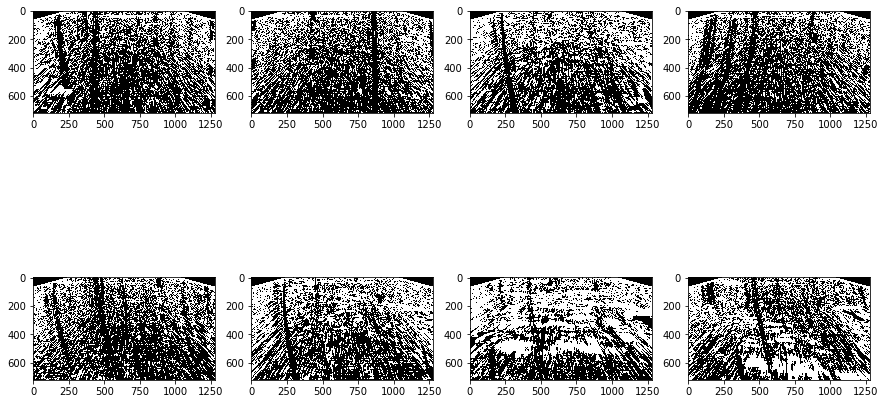

In [12]:
#Check Sobel operator
fig = plt.figure() 
thresh=(np.pi/4, np.pi/2)
sobel_kernel=15

for i in range(len(test_images)): 
    
    pic = cal_undistort(test_images[i], objpoints, imgpoints)
    pic = unwarp(pic, src, dst)
    gray = cv2.cvtColor(pic,cv2.COLOR_RGB2GRAY)
    
    #Take the (absolute) gradient in x and y separately
    abs_sobelx = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    abs_sobely = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
    
    #Calculate the direction of the gradient 
    grad = np.arctan2(abs_sobely, abs_sobelx)
    binary = np.zeros_like(grad)
    binary[(grad >= thresh[0])] = 1

   #binary[(grad >= thresh[0]) & (grad <= thresh[1])] = 1
    
    fig.add_subplot(2,4, i+1)
    plt.imshow(binary, cmap='gray')


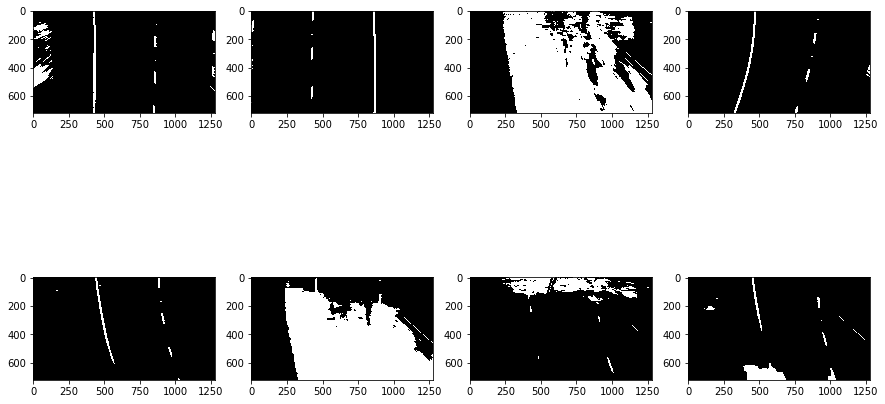

In [13]:
#Check RGB Colorspace 
fig = plt.figure()


thresh = (180, 255)

for i in range(len(test_images)):
    pic = cal_undistort(test_images[i], objpoints, imgpoints)
    pic = unwarp(pic, src, dst)
    R = pic[:,:,2]
    binary = np.zeros_like(R)
    binary[(R > thresh[0]) & (R <= thresh[1])] = 1
    
    fig.add_subplot(2,4,i+1)

    plt.imshow(binary, cmap='gray')

    



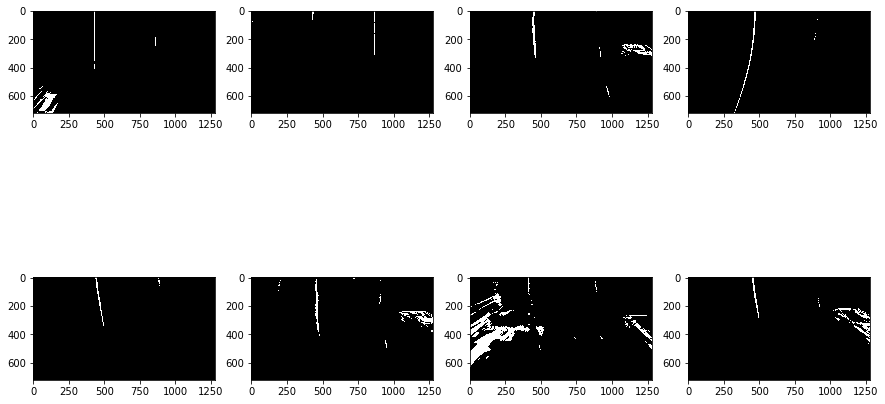

In [29]:
#Check Saturation threshold
fig = plt.figure()
threshold = (100, 255)

for i in range(len(test_images)):
    pic = cal_undistort(test_images[i], objpoints, imgpoints)
    pic = unwarp(pic, src, dst)
    hls = cv2.cvtColor(pic, cv2.COLOR_RGB2HLS)
    S = hls[:,:, 2]
    binary = np.zeros_like(S)
    binary[(S > thresh[0]) & (S <= thresh[1])] = 1
    
    fig.add_subplot(2,4,i+1)

    plt.imshow(binary, cmap='gray')

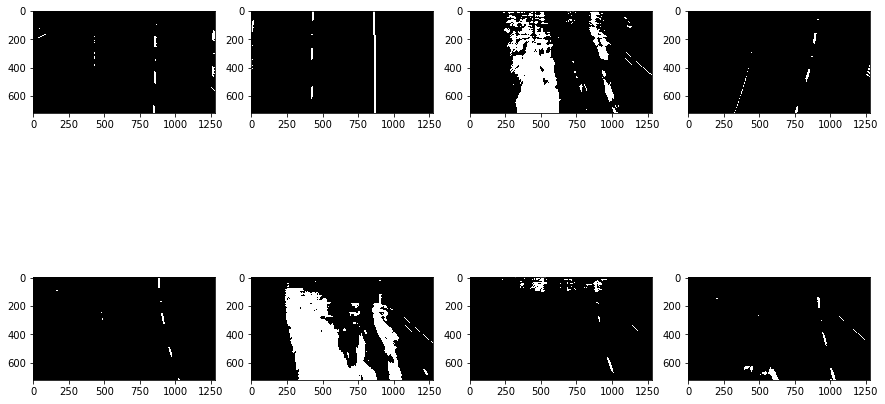

In [14]:
#Check Luminance threshold
fig = plt.figure()
threshold = (170, 255)

for i in range(len(test_images)):
    pic = cal_undistort(test_images[i], objpoints, imgpoints)
    pic = unwarp(pic, src, dst)
    hls = cv2.cvtColor(pic, cv2.COLOR_RGB2HLS)
    S = hls[:,:, 1]
    binary = np.zeros_like(S)
    binary[(S > thresh[0]) & (S <= thresh[1])] = 1
    
    fig.add_subplot(2,4,i+1)

    plt.imshow(binary, cmap='gray')

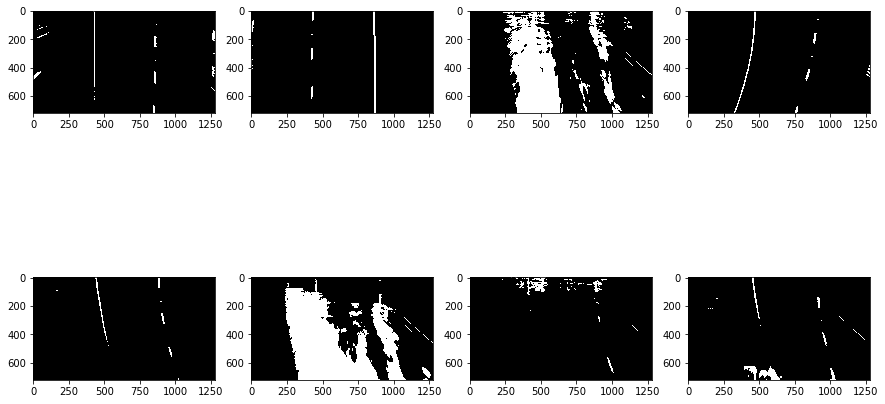

In [31]:
#Check YUV threshold
fig = plt.figure()
threshold = (200, 255)

for i in range(len(test_images)):
    pic = cal_undistort(test_images[i], objpoints, imgpoints)
    pic = unwarp(pic, src, dst)
    ycb = cv2.cvtColor(pic, cv2.COLOR_RGB2YUV)
    S = ycb[:,:, 0]
    binary = np.zeros_like(S)
    binary[(S > thresh[0]) & (S <= thresh[1])] = 1
    
    fig.add_subplot(2,4,i+1)

    plt.imshow(binary, cmap='gray')

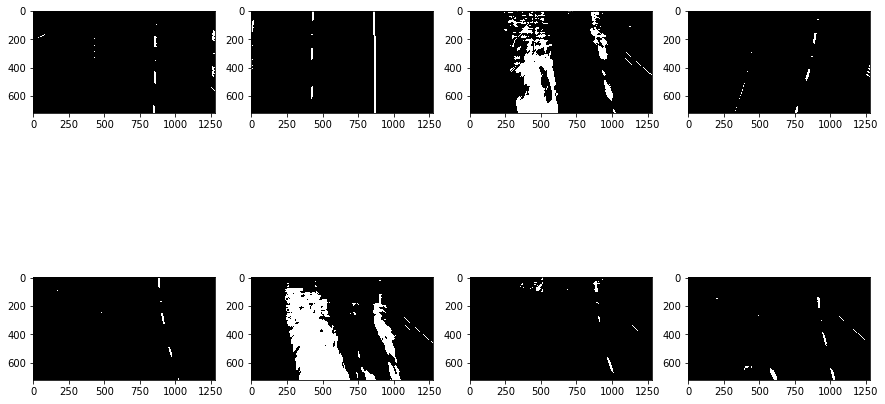

In [15]:
#Check grayscale colorspace
fig = plt.figure()
thresh = (180, 255)
for i in range(len(test_images)):
    pic = cal_undistort(test_images[i], objpoints, imgpoints)
    pic = unwarp(pic, src, dst)
    gray = cv2.cvtColor(pic, cv2.COLOR_RGB2GRAY)
    binary = np.zeros_like(gray)
    binary[(gray > thresh[0])] = 1
    fig.add_subplot(2,4,i+1)
    plt.imshow(binary, cmap='gray')


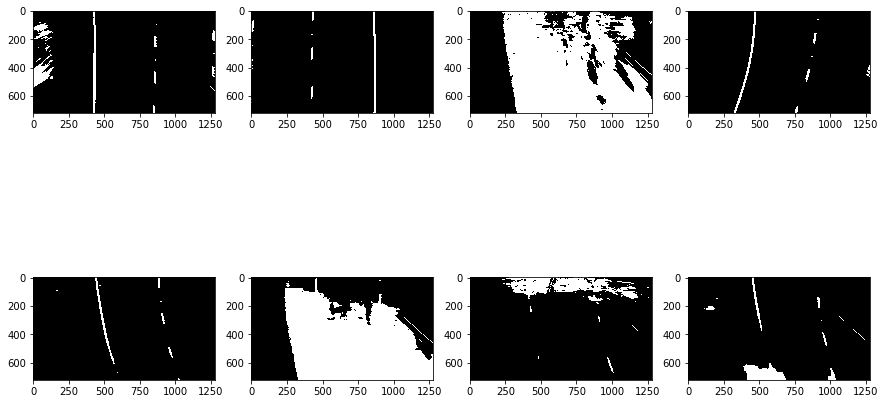

In [155]:
#Final Combination: combine input from R(RGB) and Y(YUV) channel 
binaries = []
fig = plt.figure() 
r_thresh = (180, 255)
y_thresh = (200, 255)

for i in range(len(test_images)):
    pic = cal_undistort(test_images[i], objpoints, imgpoints)
    pic = unwarp(pic, src, dst)
#    R = pic[:,:,2]
#    yuv = cv2.cvtColor(pic, cv2.COLOR_RGB2YUV)
#    Y = yuv[:,:,0]
    
#    binary_r = np.zeros_like(R)
#    binary_y = np.zeros_like(Y)
#    binary = np.zeros_like(R)
    
#    binary_r[(R >= r_thresh[0]) & (R <= r_thresh[1])] = 1
#    binary_y[(Y >= y_thresh[0]) & (Y <= y_thresh[1])] = 1
#    binary[(binary_r + binary_y >= 1)] = 1

    binary = lanes_bw(pic)
    binaries.append(binary)
    fig.add_subplot(2,4,i+1)
    plt.imshow(binary, cmap='gray')
    

In [154]:
#Function to identify lane lines from unwarped image
def lanes_bw(img):
    R = img[:,:,2]
    yuv = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    Y = yuv[:,:,0]
    
    binary_r = np.zeros_like(R)
    binary_y = np.zeros_like(Y)
    binary = np.zeros_like(R)
    
    binary_r[(R >= r_thresh[0]) & (R <= r_thresh[1])] = 1
    binary_y[(Y >= y_thresh[0]) & (Y <= y_thresh[1])] = 1
    binary[(binary_r + binary_y >= 1)] = 1
    
    return binary

# 4. Lane Lines Identification (Part 2) 

After passing through the different channels to identify the lane lines, this section will perform lane detection through the sliding window convolution method. The parameters to be tuned are the height and width of the sliding window, as well as the search margin of the window. 

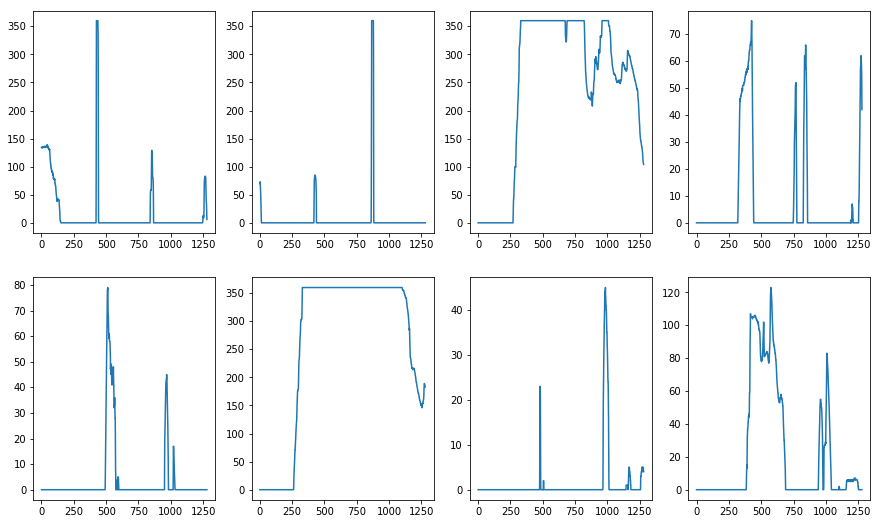

In [164]:
#Histogram of pictures before performing sliding window search 
fig = plt.figure()

for i in range(len(binaries)):
    img = binaries[i]
    histogram = np.sum(img[img.shape[0]//2:,:], axis=0)
    fig.add_subplot(2, 4, i+1)
    plt.plot(histogram)
    
plt.show()

In [19]:
#Function definitions from lesson code 
def window_mask(width, height, img_ref, center,level):
    output = np.zeros_like(img_ref)
    output[int(img_ref.shape[0]-(level+1)*height):int(img_ref.shape[0]-level*height),max(0,int(center-width/2)):min(int(center+width/2),img_ref.shape[1])] = 1
    return output

def find_window_centroids(image, window_width, window_height, margin):
    
    window_centroids = [] # Store the (left,right) window centroid positions per level
    window = np.ones(window_width) # Create our window template that we will use for convolutions
    
    # First find the two starting positions for the left and right lane by using np.sum to get the vertical image slice
    # and then np.convolve the vertical image slice with the window template 
    
    # Sum quarter bottom of image to get slice, could use a different ratio
    l_sum = np.sum(image[int(3*image.shape[0]/4):,:int(image.shape[1]/2)], axis=0)
    l_center = np.argmax(np.convolve(window,l_sum))-window_width/2
    r_sum = np.sum(image[int(3*image.shape[0]/4):,int(image.shape[1]/2):], axis=0)
    r_center = np.argmax(np.convolve(window,r_sum))-window_width/2+int(image.shape[1]/2)
    
    # Add what we found for the first layer
    window_centroids.append((l_center,r_center))
    
    # Go through each layer looking for max pixel locations
    for level in range(1,(int)(image.shape[0]/window_height)):
	    # convolve the window into the vertical slice of the image
	    image_layer = np.sum(image[int(image.shape[0]-(level+1)*window_height):int(image.shape[0]-level*window_height),:], axis=0)
	    conv_signal = np.convolve(window, image_layer)
	    # Find the best left centroid by using past left center as a reference
	    # Use window_width/2 as offset because convolution signal reference is at right side of window, not center of window
	    offset = window_width/2
	    l_min_index = int(max(l_center+offset-margin,0))
	    l_max_index = int(min(l_center+offset+margin,image.shape[1]))
	    l_center = np.argmax(conv_signal[l_min_index:l_max_index])+l_min_index-offset
	    # Find the best right centroid by using past right center as a reference
	    r_min_index = int(max(r_center+offset-margin,0))
	    r_max_index = int(min(r_center+offset+margin,image.shape[1]))
	    r_center = np.argmax(conv_signal[r_min_index:r_max_index])+r_min_index-offset
	    # Add what we found for that layer
	    window_centroids.append((l_center,r_center))

    return window_centroids




In [166]:
#Function to return the left and right points for the lane lines from the binary images
def getLaneLines(binary):
    # window settings
    window_width = 60 
    window_height = 120 # Break image into 9 vertical layers since image height is 720
    margin = 100 # How much to slide left and right for searching

    window_centroids = find_window_centroids(warped, window_width, window_height, margin)

     # If we found any window centers
    if len(window_centroids) > 0:

        # Points used to draw all the left and right windows
        l_points = np.zeros_like(warped)
        r_points = np.zeros_like(warped)
        

        # Go through each level and draw the windows 	
        for level in range(0,len(window_centroids)):
            # Window_mask is a function to draw window areas
            l_mask = window_mask(window_width,window_height,warped,window_centroids[level][0],level)
            r_mask = window_mask(window_width,window_height,warped,window_centroids[level][1],level)
            # Add graphic points from window mask here to total pixels found 
            l_points[(l_points == 255) | ((l_mask == 1) ) ] = 255
            r_points[(r_points == 255) | ((r_mask == 1) ) ] = 255
            
    
    return l_points, r_points

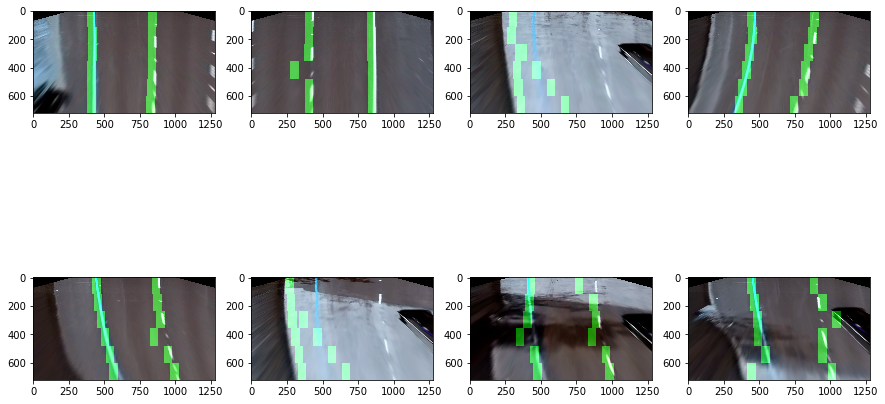

In [167]:
fig = plt.figure() 

for i in range(len(binaries)):

    # Read in a thresholded image
    warped = binaries[i]
    
#     # window settings
#     window_width = 60 
#     window_height = 120 # Break image into 9 vertical layers since image height is 720
#     margin = 100 # How much to slide left and right for searching

#     window_centroids = find_window_centroids(warped, window_width, window_height, margin)

#     # If we found any window centers
#     if len(window_centroids) > 0:

#         # Points used to draw all the left and right windows
#         l_points = np.zeros_like(warped)
#         r_points = np.zeros_like(warped)
        

#         # Go through each level and draw the windows 	
#         for level in range(0,len(window_centroids)):
#             # Window_mask is a function to draw window areas
#             l_mask = window_mask(window_width,window_height,warped,window_centroids[level][0],level)
#             r_mask = window_mask(window_width,window_height,warped,window_centroids[level][1],level)
#             # Add graphic points from window mask here to total pixels found 
#             l_points[(l_points == 255) | ((l_mask == 1) ) ] = 255
#             r_points[(r_points == 255) | ((r_mask == 1) ) ] = 255
        
    l_points, r_points = getLaneLines(warped)
    if (i ==3):
        test_pic_left = l_points
        test_pic_right = r_points


    # Draw the results
    template = np.array(r_points+l_points,np.uint8) # add both left and right window pixels together

    zero_channel = np.zeros_like(template) # create a zero color channel
    template = np.array(cv2.merge((zero_channel,template,zero_channel)),np.uint8) # make window pixels green
    pic = cal_undistort(test_images[i], objpoints, imgpoints)
    pic = unwarp(pic, src, dst)

    output = cv2.addWeighted(pic, 1, template, 0.5, 0.2) # overlay the orignal road image with window results

    # If no window centers found, just display orginal road image

    # Display the final results
    fig.add_subplot(2,4,i+1)
    plt.imshow(output)
    

plt.show()


# 5. Measuring Curvature
After identifying the lane lines in the previous section, the lane pixels identified in the previous section would be fit using a polynomial, thereby trying to fit the lane curvature. By having a pixel to dimension conversion, we are able to convert the curvature in terms of pixels to meters. This block of code would therefore calculate the curvature of the road through polynomial fitting of the results. 

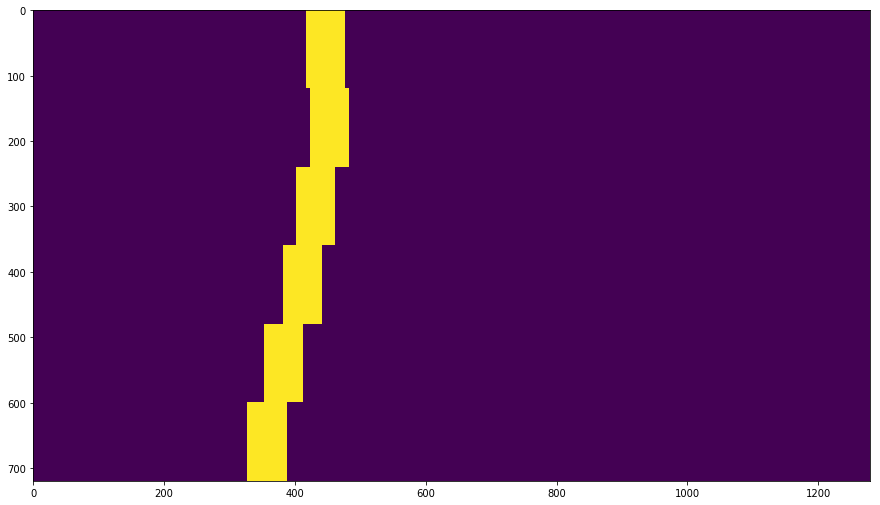

In [73]:
test_pic_left.shape
plt.imshow(test_pic_left)

In [74]:
ploty_left = []
plotx_left = []
ploty_right = []
plotx_right = []

for i in range(test_pic_left.shape[0]):
    for j in range(test_pic_left.shape[1]):
        if(test_pic_left[i,j] != 0):
            ploty_left.append(i)
            plotx_left.append(j)
            
        if(test_pic_right[i,j] != 0): 
            ploty_right.append(i)
            plotx_right.append(j)
            
plotx_left = np.array(plotx_left)
ploty_left = np.array(ploty_left)
plotx_right = np.array(plotx_right)
ploty_right = np.array(ploty_right)
        


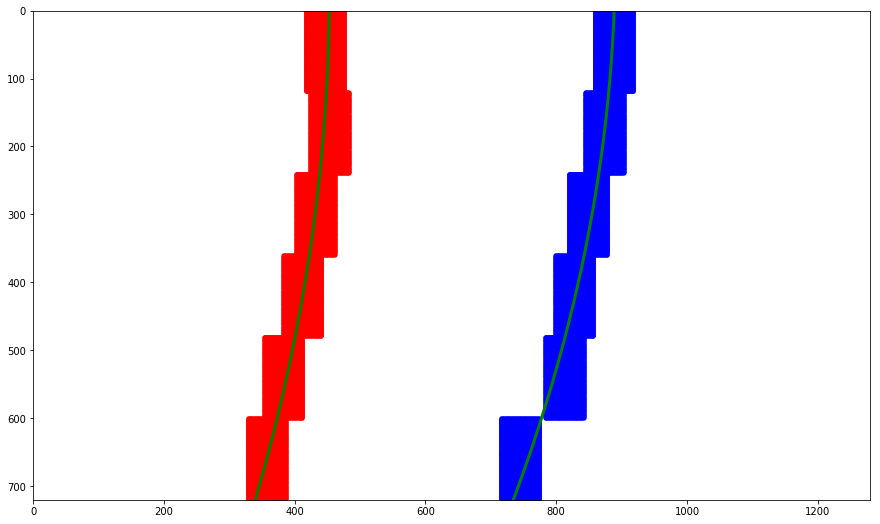

In [75]:
## Get data for left poin(ts and right points
#ploty = np.linspace(0, 719, num=720)


# Fit a second order polynomial to pixel positions in each fake lane line
left_fit = np.polyfit(ploty_left, plotx_left, 2)
left_fitx = left_fit[0]*ploty_left**2 + left_fit[1]*ploty_left + left_fit[2]
right_fit = np.polyfit(ploty_right, plotx_right, 2)
right_fitx = right_fit[0]*ploty_right**2 + right_fit[1]*ploty_right + right_fit[2]

# Plot up the fake data
mark_size = 3
plt.plot(plotx_left, ploty_left, 'o', color='red', markersize=mark_size)
plt.plot(plotx_right, ploty_right, 'o', color='blue', markersize=mark_size)
plt.xlim(0, 1280)
plt.ylim(0, 720)
plt.plot(left_fitx, ploty_left, color='green', linewidth=3)
plt.plot(right_fitx, ploty_right, color='green', linewidth=3)
plt.gca().invert_yaxis() # to visualize as we do the images


In [190]:
# Define y-value where we want radius of curvature
# I'll choose the maximum y-value, corresponding to the bottom of the image
y_eval = np.max(np.append(ploty_left, ploty_right))
left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
print(left_curverad, right_curverad)

# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

# Fit new polynomials to x,y in world space
left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)

# Calculate the new radii of curvature
left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
curve_rad = 0.5*(left_curverad + right_curverad)

h = 720
w = 1280

if right_fit is not None and left_fit is not None:
        car_position = w/2
        l_fit_x_int = left_fit[0]*h**2 + left_fit[1]*h + left_fit[2]
        r_fit_x_int = right_fit[0]*h**2 + right_fit[1]*h + right_fit[2]
        lane_center_position = (r_fit_x_int + l_fit_x_int) /2
        center_dist = (car_position - lane_center_position) * xm_per_pix

# Now our radius of curvature is in meters
print(left_curverad, 'm', right_curverad, 'm',)
print("center distance, ", center_dist)
# Example values: 632.1 m    626.2 m


2828.359416815124 2557.1202782018345
500.58399823508955 m 565.5151988166372 m
center distance,  0.543775617323071


# 6. Superimposing Results with Image
This section builds the function to superimpose the results obtained earlier into the image and unwarp 

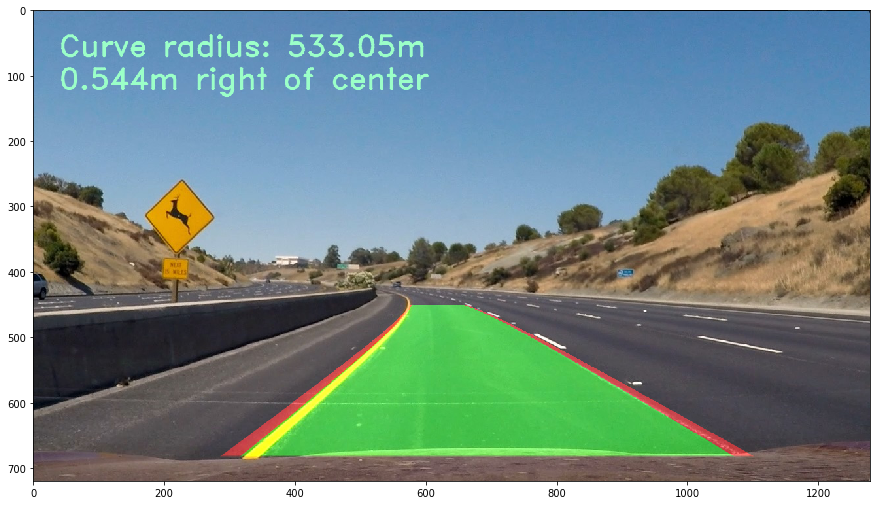

In [197]:
#Reformat plot_left and plot_right into vertices
blank = np.zeros_like(test_images[3])
pts_left = np.array(np.transpose(np.vstack([left_fitx, ploty_left])))
pts_right = np.array(np.flipud(np.transpose(np.vstack([right_fitx, ploty_right]))))
pts = np.vstack((pts_left, pts_right))

# Draw the lane onto the warped blank image
cv2.fillPoly(blank, np.int_([pts]), (0, 255, 0))
cv2.polylines(blank, np.int32([pts_left]), isClosed=False, color=(0,0,255), thickness=15)
cv2.polylines(blank, np.int32([pts_right]), isClosed=False, color=(0,0,255), thickness=15)

# Warp the blank back to original image space using inverse perspective matrix (Minv)
newwarp = unwarp(blank, dst, src)
# Combine the result with the original image
result = cv2.addWeighted(test_images[3], 1, newwarp, 0.5, 0)
result = draw_data(result, curve_rad, center_dist)
plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))



   

In [196]:
def draw_data(original_img, curv_rad, center_dist):
    result = np.copy(original_img)
    h = result.shape[0]
    font = cv2.FONT_HERSHEY_DUPLEX
    text = 'Curve radius: ' + '{:04.2f}'.format(curv_rad) + 'm'
    cv2.putText(result, text, (40,70), font, 1.5, (200,255,155), 2, cv2.LINE_AA)
    direction = ''
    if center_dist > 0:
        direction = 'right'
    elif center_dist < 0:
        direction = 'left'
    abs_center_dist = abs(center_dist)
    text = '{:04.3f}'.format(abs_center_dist) + 'm ' + direction + ' of center'
    cv2.putText(result, text, (40,120), font, 1.5, (200,255,155), 2, cv2.LINE_AA)
    return result


# Image pipeline
Function definition to return an image through the processing pipeline 

In [ ]:
def pipeline(image): 
    